In [288]:
import pandas as pd
from pandas import Series, DataFrame
import matplotlib as mpl
mpl.use('agg')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(color_codes=True)

In [289]:
df = pd.read_excel('US_Election_2008.xlsx')
df = df[:72]

In [290]:
df[69:]

,group_id,group_size,gay_marriage,free_trade,abortion,immigration,iraq,econ,Registered,voted,voted_obama,gm_likeobama,econ_mostimportant,econ_goodobama,econ_goodmccain,econ_badobama,econ-badmccain
69,70,179.0,2.196629,2.304598,3.310735,2.718391,1.670454,1.145251,0.955307,0.903955,0.865922,0.446927,0.798883,0.826816,0.016760,0.022346,0.731844
70,71,352.0,2.017143,2.401734,3.247813,2.833333,1.790831,1.145299,0.951429,0.897727,0.855114,0.437500,0.778409,0.781250,0.031250,0.039773,0.684659
71,72,243.0,2.462810,2.455696,3.454546,2.736402,1.692946,1.107884,0.938272,0.905350,0.860082,0.390946,0.765432,0.711934,0.049383,0.012346,0.567901


In [291]:
# candidates' positions
# properly normalized 6-dim objective position data

<H2> Preliminary Work to Normalize Input Variables

In [292]:
def normalize_by_n(value, choice_count):
    slope = 2.0/(choice_count-1)
    intercept = -(1+slope)
    normalized_value = value*slope + intercept
    return normalized_value

In [293]:
n_gay_marriage = [normalize_by_n(x,3) for x in df.gay_marriage]
n_iraq = [normalize_by_n(x,3) for x in df.iraq]
n_immigration = [normalize_by_n(x,4) for x in df.immigration]
n_free_trade = [normalize_by_n(x,4) for x in df.free_trade]
n_abortion = [normalize_by_n(x,4) for x in df.abortion]

In [294]:
n_econ = []
for i in range(0,len(df)):
    x = df.econ_goodmccain[i]
    y = df.econ_goodobama[i]
    abs_econ = y - x
    n_econ.append(abs_econ)

n_econ = pd.Series(n_econ)

In [310]:
df_normalized = df
df_normalized.gay_marriage = n_gay_marriage
df_normalized.iraq = n_iraq
df_normalized.immigration = n_immigration
df_normalized.free_trade = n_free_trade
df_normalized.abortion = n_abortion
df_normalized.econ = n_econ

po = df.iloc[[59,69]].mean()
pm = df.iloc[[0,1]].mean()
po.econ = 1
pm.econ = -1

In [311]:
# drop columns if the group size is less than 50
df_nf = df_normalized
for i in range(0,len(df_normalized)):
    if df_nf.group_size[i] < 50:
        df_nf = df_nf.drop([i])
        
df_nf = df_nf.reset_index()
df_nf = df_nf.drop(['index'],axis=1)
df_nf.describe()

,group_size,gay_marriage,free_trade,abortion,immigration,iraq,econ,Registered,voted,voted_obama,gm_likeobama,econ_mostimportant,econ_goodobama,econ_goodmccain,econ_badobama,econ-badmccain
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,366.116279,-0.032068,-0.107865,0.259708,0.114160,0.061476,0.144460,0.923732,0.863260,0.467289,0.217813,0.648558,0.392593,0.248133,0.267415,0.342971
std,238.345009,0.345766,0.090690,0.292670,0.072984,0.342619,0.519855,0.046453,0.064765,0.334016,0.161545,0.097809,0.296117,0.228691,0.240344,0.257916
min,50.000000,-0.522936,-0.285403,-0.144804,-0.094340,-0.329546,-0.523551,0.803419,0.682864,0.052536,0.000000,0.493739,0.036232,0.000000,0.012346,0.039720
25%,151.000000,-0.304662,-0.162456,-0.028363,0.074690,-0.245953,-0.419876,0.904913,0.830882,0.111188,0.059357,0.547645,0.078690,0.044374,0.049947,0.069982
50%,328.000000,-0.117188,-0.130268,0.276067,0.130000,-0.153344,0.418750,0.930195,0.885802,0.621622,0.220159,0.668342,0.490625,0.083933,0.107914,0.468750
75%,576.500000,0.200275,-0.031546,0.515364,0.154363,0.407858,0.637656,0.961362,0.904652,0.787463,0.352108,0.738647,0.675655,0.496863,0.500709,0.567260
max,856.000000,0.699198,0.079038,0.808121,0.274423,0.557512,0.810056,0.982644,0.955882,0.885180,0.518024,0.798883,0.826816,0.600000,0.644860,0.731844


<h2> Spatial-Utility Computations

In [312]:
group_utility_obama = []
group_utility_mccain = []
group_utility_obama_weighted = []
group_utility_mccain_weighted = []

alpha = 3.0

issues = ['gay_marriage', 'free_trade', 'abortion', 'immigration', 'iraq', 'econ']

for i in range(0,len(df_nf)):
    guo = 0
    guo_w = 0
    gum = 0
    gum_w = 0
    
    for issue in issues:
        utility_o = 1.0 - alpha*np.square((df_nf[issue][i]-po[issue]))
        utility_m = 1.0 - alpha*np.square((df_nf[issue][i]-pm[issue]))
        guo = guo + utility_o
        gum = gum + utility_m
    
    guo_w = (df_nf.econ_mostimportant[i]*6-1)*(1.0 - alpha*np.square((df_nf['econ'][i]-po['econ'])))
    gum_w = (df_nf.econ_mostimportant[i]*6-1)*(1.0 - alpha*np.square((df_nf['econ'][i]-pm['econ'])))
    
    group_utility_mccain.append(gum)
    group_utility_obama.append(guo)
    group_utility_mccain_weighted.append(gum_w)
    group_utility_obama_weighted.append(guo_w)


In [313]:
df_nf['voted_mccain'] = [1-x for x in df_nf.voted_obama]

<h2> Regression Analysis

<h3> Unweigthed Setting

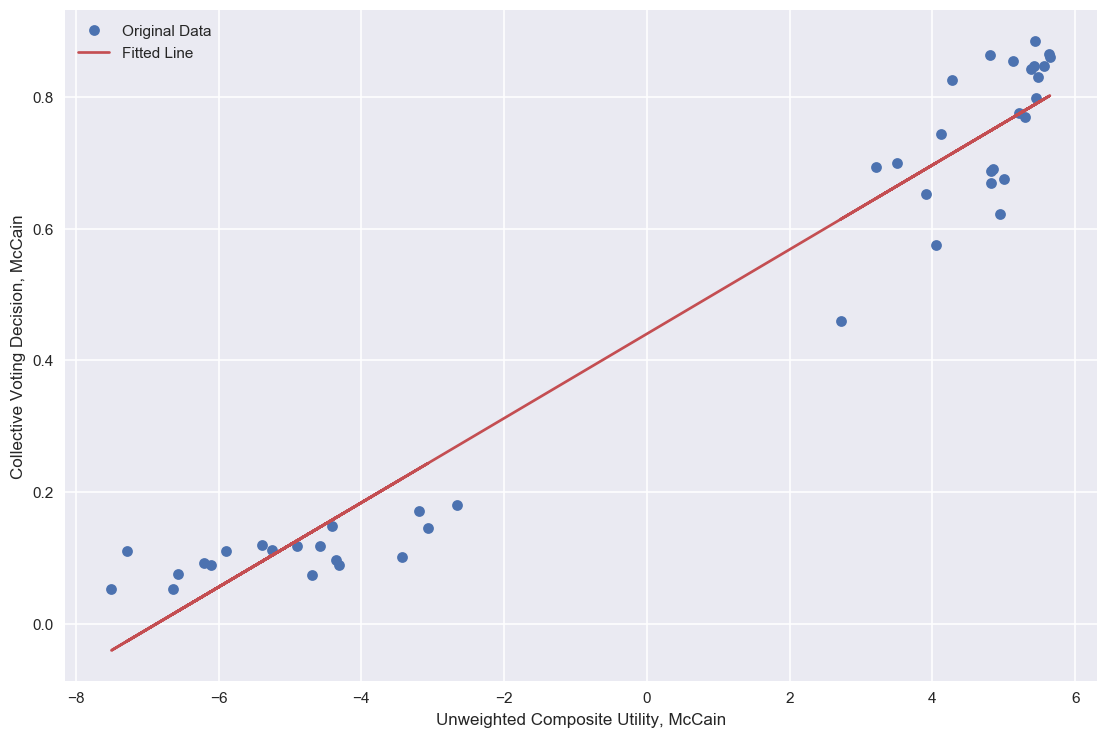

In [333]:
import scipy

x = np.asarray(group_utility_obama)
y = np.asarray(df_nf.voted_obama)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

plt.figure(num=None, figsize=(12, 8), dpi=111, facecolor='w', edgecolor='k')

plt.plot(x,y, 'o', label='Original Data')
plt.plot(x, intercept + slope*x, 'r', label='Fitted Line')
plt.xlabel('Unweighted Composite Utility, McCain')
plt.ylabel('Collective Voting Decision, McCain')
plt.legend()
plt.show()



In [334]:
slope, intercept, r_value, p_value, std_err

(0.064108145526357282,
 0.44017782876063821,
 0.97445812386235486,
 3.2282490462625327e-28,
 0.0023073233760835554)

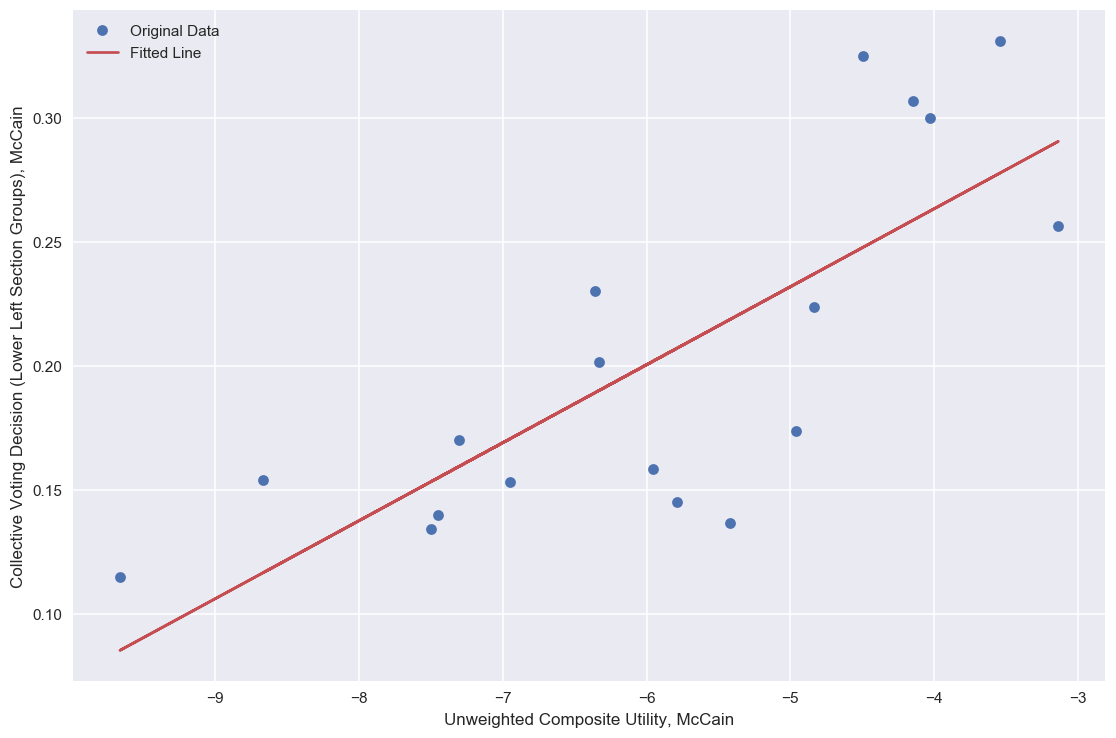

In [316]:
import scipy

x = np.asarray(group_utility_mccain[25:])
y = np.asarray(df_nf.voted_mccain[25:])

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

plt.figure(num=None, figsize=(12, 8), dpi=111, facecolor='w', edgecolor='k')

plt.plot(x,y, 'o', label='Original Data')
plt.plot(x, intercept + slope*x, 'r', label='Fitted Line')
plt.xlabel('Unweighted Composite Utility, McCain')
plt.ylabel('Collective Voting Decision (Lower Left Section Groups), McCain')
plt.legend()
plt.show()




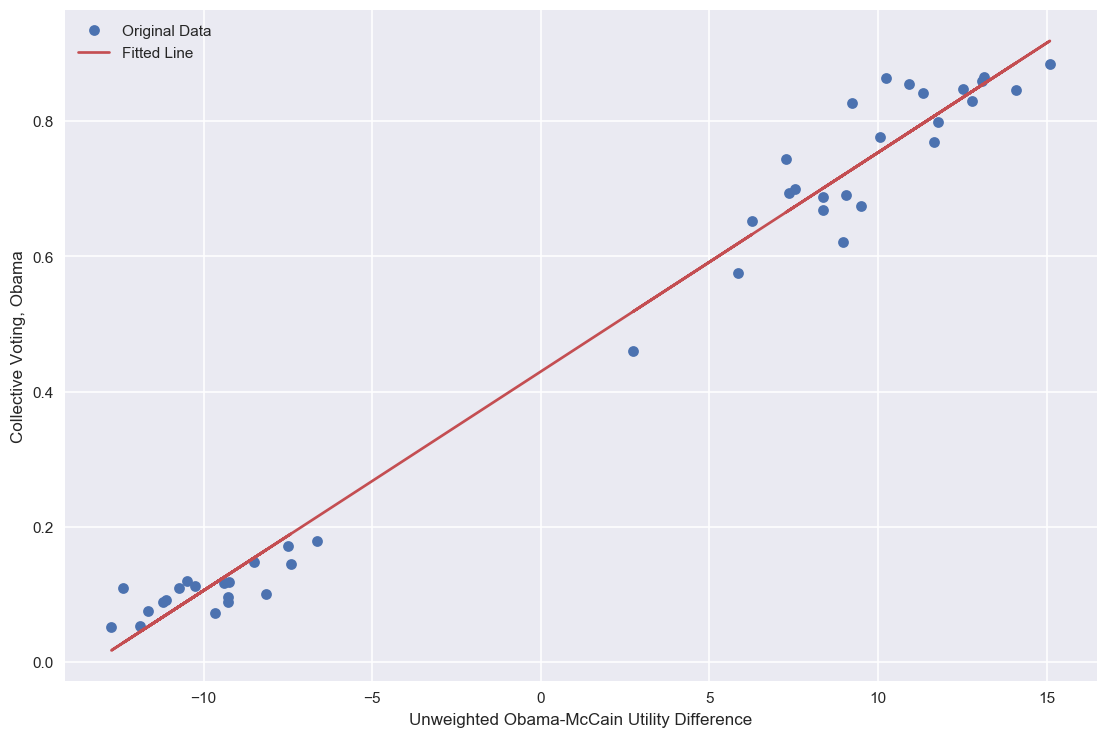

In [317]:
om_utility_difference = [x-y for x,y in zip(group_utility_obama,group_utility_mccain)]

x = np.asarray(om_utility_difference)
y = np.asarray(df_nf.voted_obama)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

plt.figure(num=None, figsize=(12, 8), dpi=111, facecolor='w', edgecolor='k')

plt.plot(x,y, 'o', label='Original Data')
plt.plot(x, intercept + slope*x, 'r', label='Fitted Line')
plt.xlabel('Unweighted Obama-McCain Utility Difference')
plt.ylabel('Collective Voting, Obama')
plt.legend()
plt.show()

In [318]:
slope, intercept, r_value, p_value, std_err

(0.032374500287967053,
 0.42994103018486785,
 0.9908946954526463,
 2.4700922611771517e-37,
 0.00068699729122194029)

<h3> Weighted Setting, econ_mostimportant

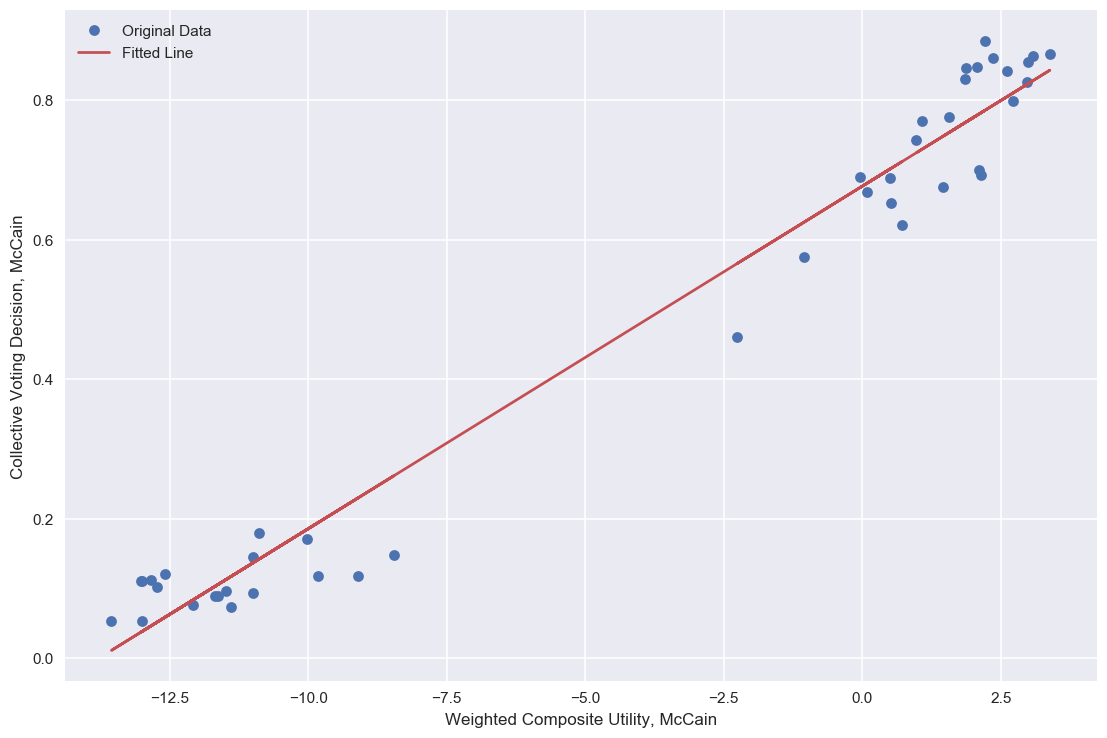

In [338]:
import scipy

x = np.asarray(group_utility_obama_weighted)
y = np.asarray(df_nf.voted_obama)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

plt.figure(num=None, figsize=(12, 8), dpi=111, facecolor='w', edgecolor='k')

plt.plot(x,y, 'o', label='Original Data')
plt.plot(x, intercept + slope*x, 'r', label='Fitted Line')
plt.xlabel('Weighted Composite Utility, McCain')
plt.ylabel('Collective Voting Decision, McCain')
plt.legend()
plt.show()


In [339]:
slope, intercept, r_value, p_value, std_err

(0.04915248984783209,
 0.67689141037700329,
 0.98483603378303652,
 8.1141128540695233e-33,
 0.0013522543442813636)

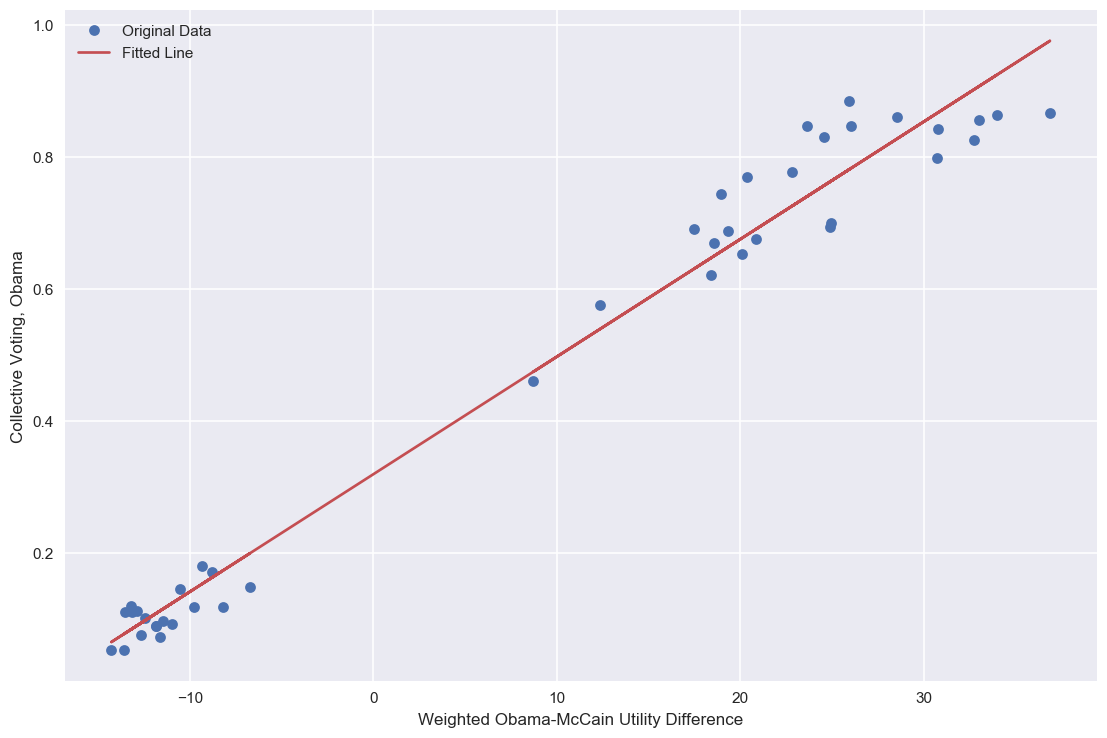

In [320]:
om_utility_difference_w = [x-y for x,y in zip(group_utility_obama_weighted,group_utility_mccain_weighted)]

x = np.asarray(om_utility_difference_w)
y = np.asarray(df_nf.voted_obama)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

plt.figure(num=None, figsize=(12, 8), dpi=111, facecolor='w', edgecolor='k')

plt.plot(x,y, 'o', label='Original Data')
plt.plot(x, intercept + slope*x, 'r', label='Fitted Line')
plt.xlabel('Weighted Obama-McCain Utility Difference')
plt.ylabel('Collective Voting, Obama')
plt.legend()
plt.show()

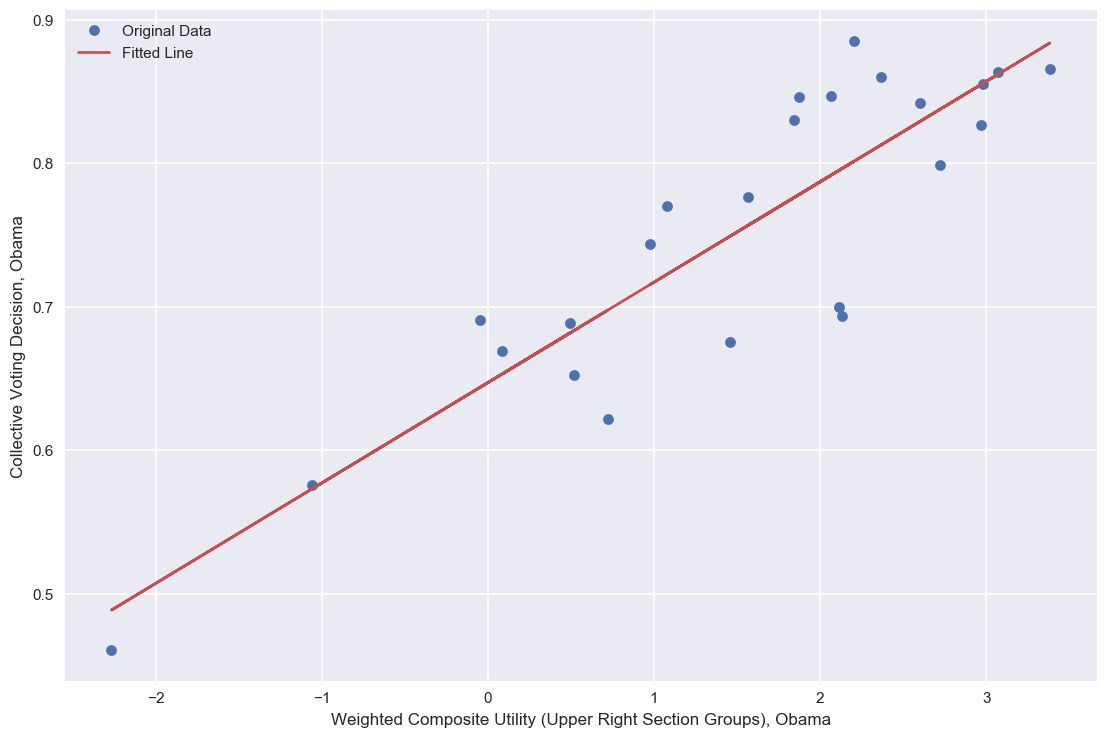

In [321]:
import scipy

x = np.asarray(group_utility_obama_weighted[19:])
y = np.asarray(df_nf.voted_obama[19:])

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

plt.figure(num=None, figsize=(12, 8), dpi=111, facecolor='w', edgecolor='k')

plt.plot(x,y, 'o', label='Original Data')
plt.plot(x, intercept + slope*x, 'r', label='Fitted Line')
plt.xlabel('Weighted Composite Utility (Upper Right Section Groups), Obama')
plt.ylabel('Collective Voting Decision, Obama')
plt.legend()
plt.show()



In [322]:
slope, intercept, r_value, p_value, std_err

(0.069988562002020235,
 0.64700597044609831,
 0.88199806156184202,
 1.2214793822000451e-08,
 0.0079726418709562073)

<h3> Voter Participation Rate

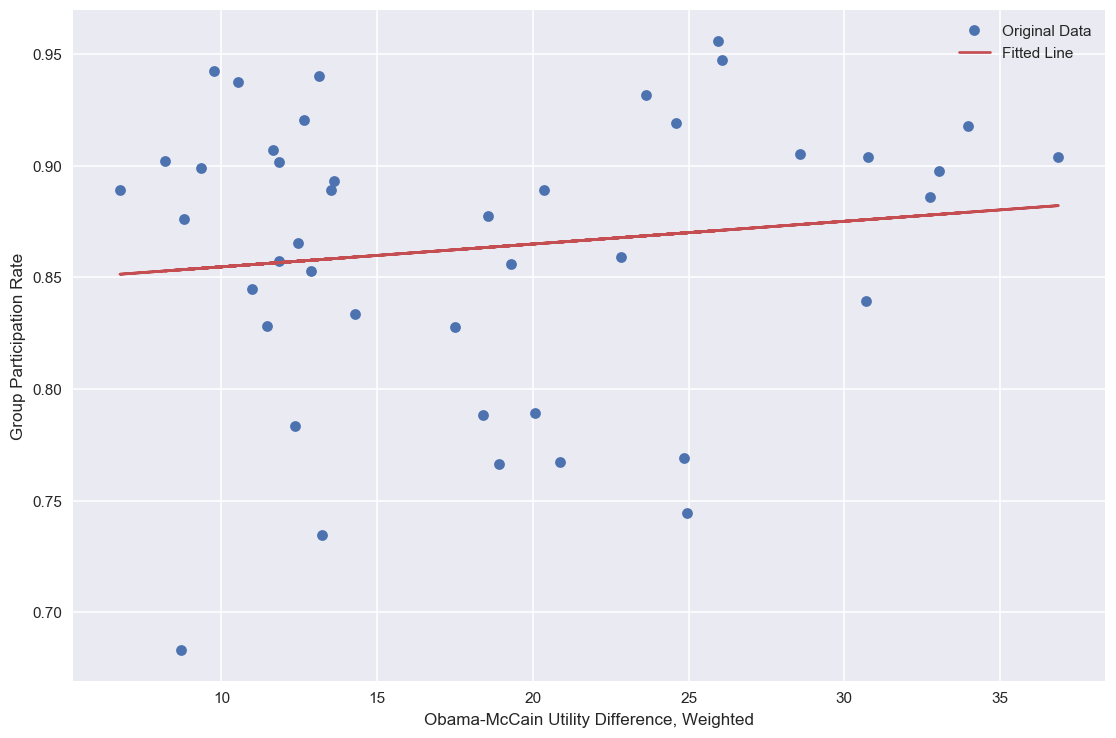

In [357]:
om_utility_difference_weighted = [abs(x-y) for x,y in zip(group_utility_obama_weighted,group_utility_mccain_weighted)]

x = np.asarray(om_utility_difference_weighted)
y = np.asarray(df_nf.voted)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

plt.figure(num=None, figsize=(12, 8), dpi=111, facecolor='w', edgecolor='k')

plt.plot(x,y, 'o', label='Original Data')
plt.plot(x, intercept + slope*x, 'r', label='Fitted Line')
plt.xlabel('Obama-McCain Utility Difference, Weighted')
plt.ylabel('Group Participation Rate')
plt.legend()
plt.show()

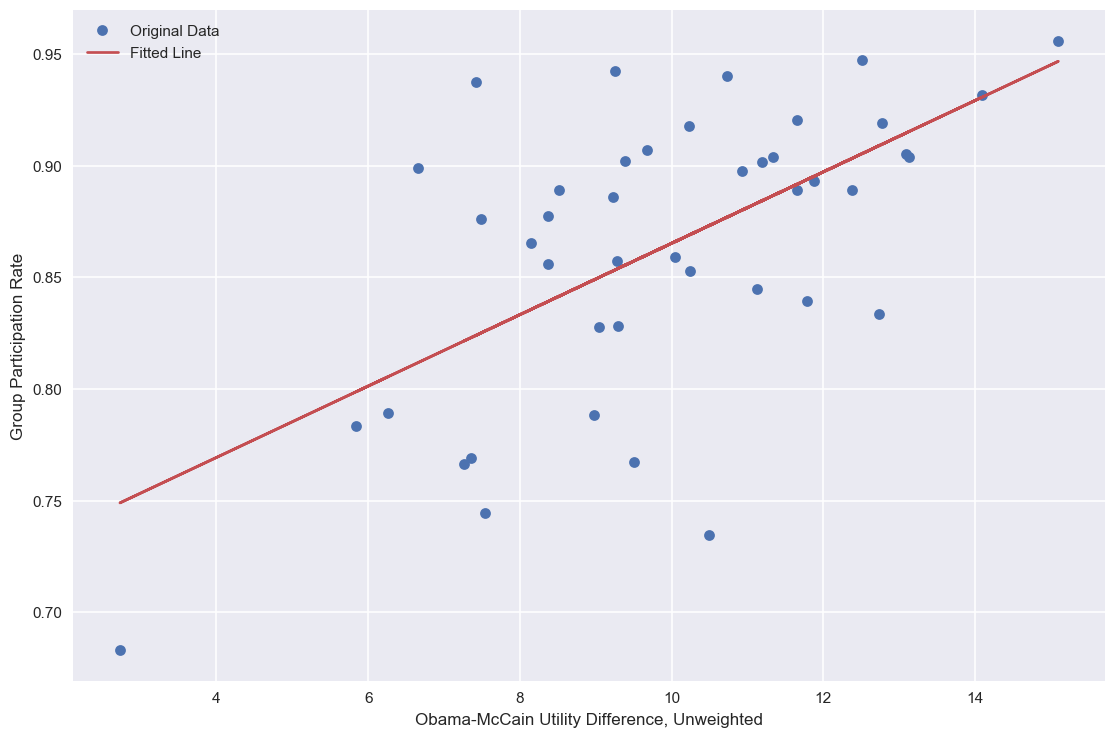

In [355]:
om_utility_difference_unweighted = [abs(x-y) for x,y in zip(group_utility_obama,group_utility_mccain)]

x = np.asarray(om_utility_difference_unweighted)
y = np.asarray(df_nf.voted)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

plt.figure(num=None, figsize=(12, 8), dpi=111, facecolor='w', edgecolor='k')

plt.plot(x,y, 'o', label='Original Data')
plt.plot(x, intercept + slope*x, 'r', label='Fitted Line')
plt.xlabel('Obama-McCain Utility Difference, Unweighted')
plt.ylabel('Group Participation Rate')
plt.legend()
plt.show()

In [358]:
slope, intercept, r_value, p_value, std_err

(0.0010197436549111776,
 0.84448923387940322,
 0.12954506864507837,
 0.4076992993707993,
 0.0012189983698055503)